In [ ]:
from jax import jit, vmap
import jax.numpy as jnp


def sample_from_theta (key, theta):
    A, B, g, k = theta
    z = jax.random.normal(key, shape=(n_obs, 1))
    c = 0.8

    samples = A + B * (1 + c * jnp.tanh(g * z / 2)) * (1 + z**2) ** k * z
    samples = jnp.sort(samples, axis=0)
    return samples

@jit
def sample_theta_and_ordered_G_and_K(key):
    key, key_prior, key_data = jax.random.split(key, 3)
    theta = jax.random.uniform(key_prior, shape= (4,), minval=0., maxval=10.)
    A, B, g, k = theta
    z = jax.random.normal(key_data, shape=(n_obs, 1))
    c = 0.8

    samples = A + B * (1 + c * jnp.tanh(g * z / 2)) * (1 + z**2) ** k * z
    samples = jnp.sort(samples, axis=0)
    
    samples2 = jnp.sort(samples**2, axis=0)
    samples3 = samples**3
    samples4 = jnp.sort(samples**4, axis=0)
    return theta, samples, samples2, samples3, samples4

sample_joint = vmap(sample_theta_and_ordered_G_and_K, in_axes=(0,))


In [ ]:
n_samples = 100000
n_obs = 1000

summary_quantiles = jnp.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
n_quantiles = summary_quantiles.shape[0]

true_theta = jnp.array([3., 1., 2., .5])
key, key_xobs= jax.random.split(key)
x_obs = sample_from_theta(key_xobs, true_theta)
keys = jax.random.split(key_xobs, n_samples)
thetas, xs = sample_joint(keys)

KeyboardInterrupt: 

In [ ]:
import jax.numpy as jnp
from jax import lax





def median(x: jnp.ndarray) -> jnp.ndarray:
    """
    Median over samples.
    - x: (n_samples, d) or (n_batch, n_samples, d)
    """
    if x.ndim == 2:
        return jnp.median(x, axis=0)  # (d,)
    elif x.ndim == 3:
        return jnp.median(x, axis=1)  # (n_batch, d)
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")


def iqr(x: jnp.ndarray) -> jnp.ndarray:
    """
    Interquartile range: Q75 - Q25.
    """
    if x.ndim == 2:
        q75 = jnp.percentile(x, 75, axis=0)
        q25 = jnp.percentile(x, 25, axis=0)
    elif x.ndim == 3:
        q75 = jnp.percentile(x, 75, axis=1)
        q25 = jnp.percentile(x, 25, axis=1)
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")
    return q75 - q25


def skewness(x: jnp.ndarray) -> jnp.ndarray:
    """
    Skewness over samples.
    """
    if x.ndim == 2:
        mean = jnp.mean(x, axis=0)
        std = jnp.std(x, axis=0)
        skew = jnp.mean(((x - mean) / std) ** 3, axis=0)
    elif x.ndim == 3:
        mean = jnp.mean(x, axis=1, keepdims=True)
        std = jnp.std(x, axis=1, keepdims=True)
        skew = jnp.mean(((x - mean) / std) ** 3, axis=1)
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")
    return skew


def octile_spread(x: jnp.ndarray) -> jnp.ndarray:
    """
    Octile spread: Q87.5 - Q12.5, proxy for kurtosis.
    """
    if x.ndim == 2:
        q875 = jnp.percentile(x, 87.5, axis=0)
        q125 = jnp.percentile(x, 12.5, axis=0)
    elif x.ndim == 3:
        q875 = jnp.percentile(x, 87.5, axis=1)
        q125 = jnp.percentile(x, 12.5, axis=1)
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")
    return q875 - q125

def deciles(x: jnp.ndarray, k: int) -> jnp.ndarray:
    """
    Deciles: Q10, Q20, ..., Q90.
    Returns:
        (9,d) if x.ndim == 2
        (n_batch, 9, d) if x.ndim == 3
    """
    if x.ndim == 2:
        return jnp.percentile(x**k, jnp.arange(10, 100, 10), axis=0).flatten()
    elif x.ndim == 3:
        return jnp.percentile(x**k, jnp.arange(10, 100, 10), axis=1).swapaxes(0, 1)[:,:,0]
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")



def order_stats(x: jnp.ndarray, k: int) -> jnp.ndarray:
    """
    Order statistics: X(1)^k, X(2)^k, ..., X(n)^k for each sample.
    Returns:
        (n_samples, n_obs) if x.ndim == 2
        (n_batch, n_samples, n_obs) if x.ndim == 3
    """
    if x.ndim == 2:
        return jnp.sort(x**k, axis=0)  # Sort along the first axis
    elif x.ndim == 3:
        return jnp.sort(x**k, axis=1)
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")


def centiles(x: jnp.ndarray, k: int =1 ) -> jnp.ndarray:
    """
    Centiles: Q1, Q2, ..., Q99.
    Returns:
        (99,d) if x.ndim == 2
        (n_batch, 99, d) if x.ndim == 3
    """
    if x.ndim == 2:
        return jnp.percentile(x**k, jnp.arange(1, 100), axis=0).flatten()
    elif x.ndim == 3:
        return jnp.percentile(x**k, jnp.arange(1, 100), axis=1).swapaxes(0, 1)[:,:,0]
    else:
        raise ValueError(f"Unsupported ndim {x.ndim}")
    


meds = median(xs)
med_xobs = median(x_obs)

iqrs = iqr(xs)
iqr_xobs = iqr(x_obs)

skews = skewness(xs)
skew_xobs = skewness(x_obs)

octiles = octile_spread(xs)
octile_xobs = octile_spread(x_obs)

deciles_xs = deciles(xs, k=1)
deciles_xobs = deciles(x_obs, k=1)

deciles2_xs = deciles(xs, k=2)
deciles2_xobs = deciles(x_obs, k=2)

deciles3_xs = deciles(xs, k=3)
deciles3_xobs = deciles(x_obs, k=3)

deciles4_xs = deciles(xs, k=4)
deciles4_xobs = deciles(x_obs, k=4)

order_stats_xs = order_stats(xs, k=1)
order_stats_xobs = order_stats(x_obs, k=1)

order_stats2_xs = order_stats(xs, k=2)
order_stats2_xobs = order_stats(x_obs, k=2)

order_stats3_xs = order_stats(xs, k=3)
order_stats3_xobs = order_stats(x_obs, k=3)

order_stats4_xs = order_stats(xs, k=4)
order_stats4_xobs = order_stats(x_obs, k=4)

centiles_xs = centiles(xs, k=1)
centiles_xobs = centiles(x_obs, k=1)   

centiles2_xs = centiles(xs, k=2)
centiles2_xobs = centiles(x_obs, k=2)

centiles3_xs = centiles(xs, k=3)
centiles3_xobs = centiles(x_obs, k=3)

centiles4_xs = centiles(xs, k=4)
centiles4_xobs = centiles(x_obs, k=4)

# print(f"meds shape: {meds.shape}, med_xobs shape: {med_xobs.shape}")
# print(f"iqrs shape: {iqrs.shape}, iqr_xobs shape: {iqr_xobs.shape}")
# print(f"skews shape: {skews.shape}, skew_xobs shape: {skew_xobs.shape}")
# print(f"octiles shape: {octiles.shape}, octile_xobs shape: {octile_xobs.shape}")
# print(f"s_xs shape: {s_xs.shape}, s_xobs shape: {s_xobs.shape}")
# print(f"deciles_xs shape: {deciles_xs.shape}, deciles_xobs shape: {deciles_xobs.shape}")

Shapes: summary: (100000, 1), summary_xobs: (1,)


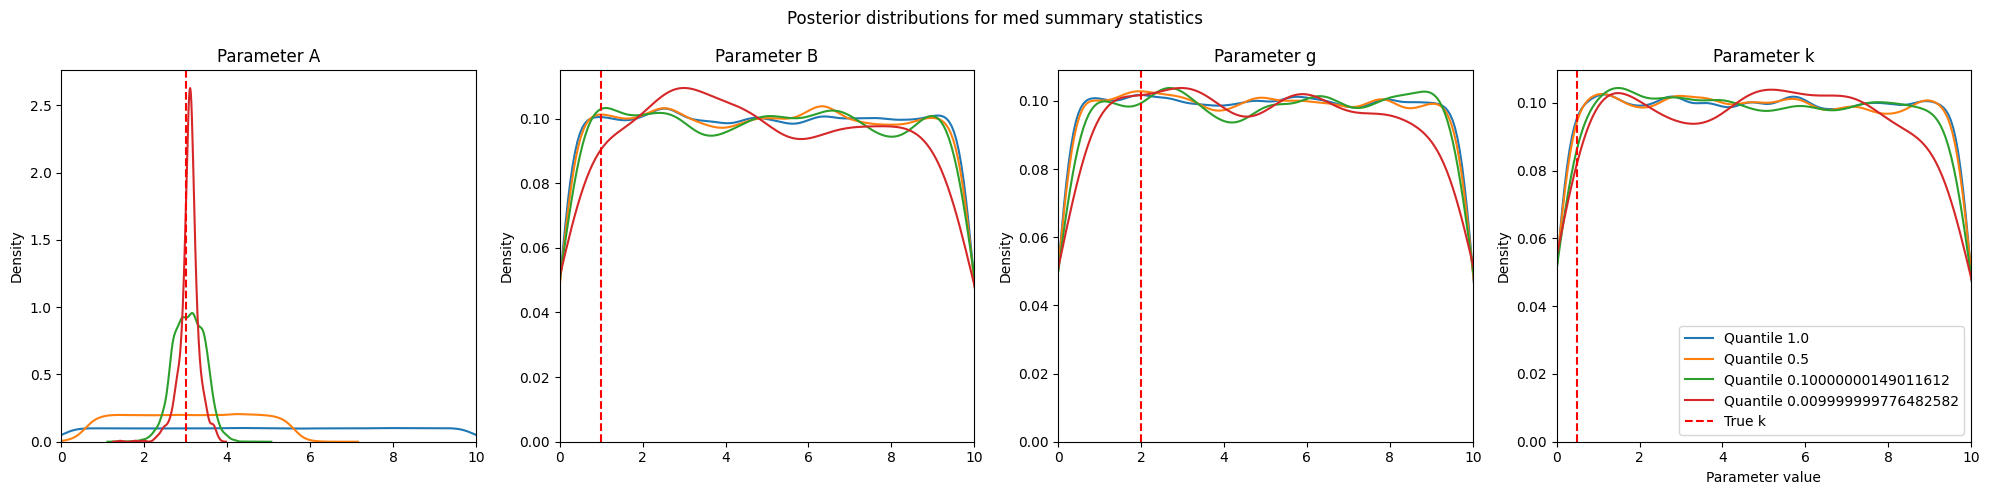

Shapes: summary: (100000, 1), summary_xobs: (1,)


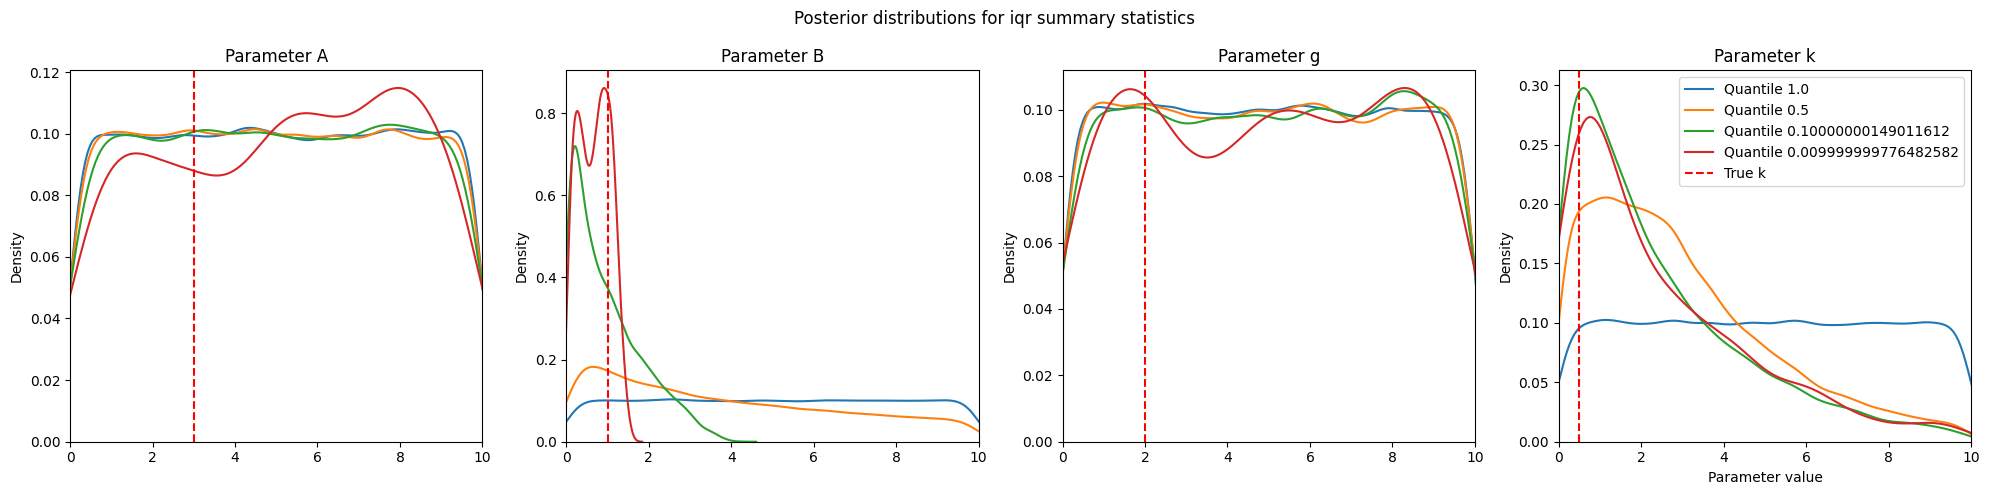

Shapes: summary: (100000, 1), summary_xobs: (1,)


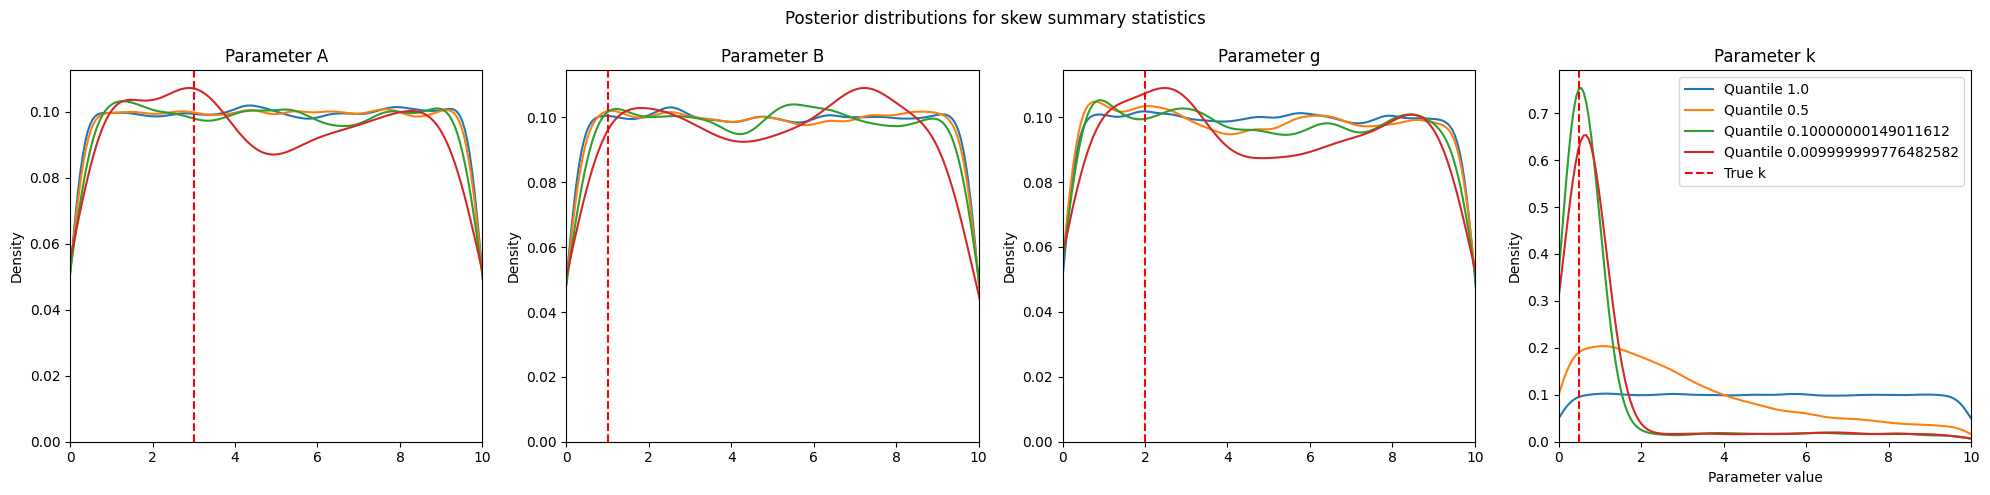

Shapes: summary: (100000, 1), summary_xobs: (1,)


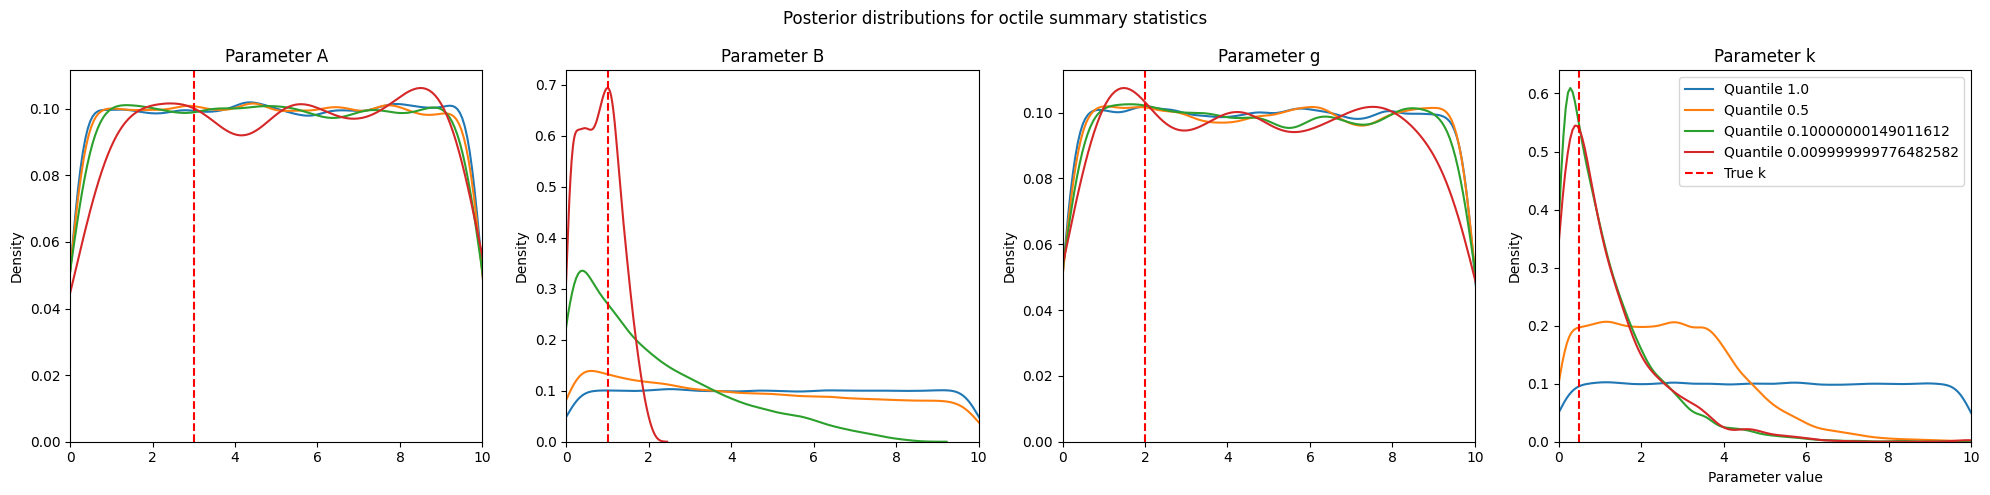

Shapes: summary: (100000, 9), summary_xobs: (9,)


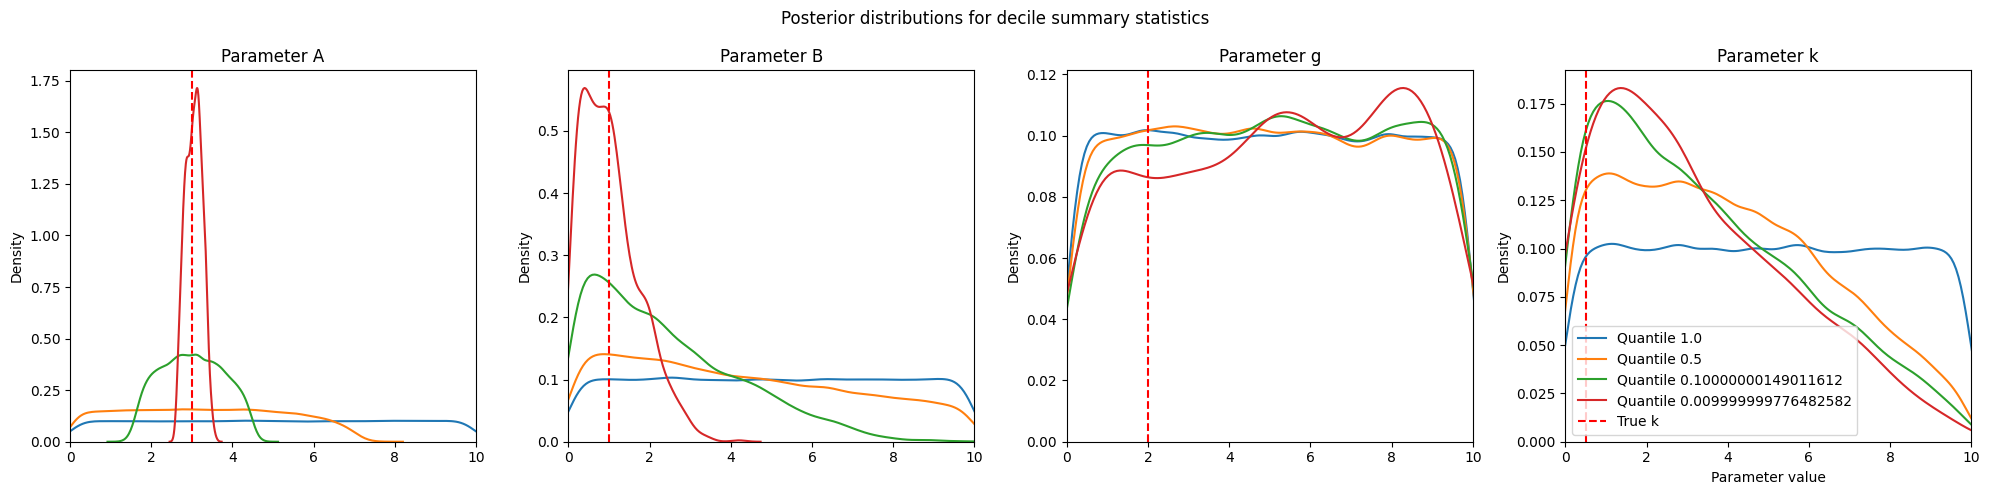

Shapes: summary: (100000, 9), summary_xobs: (9,)


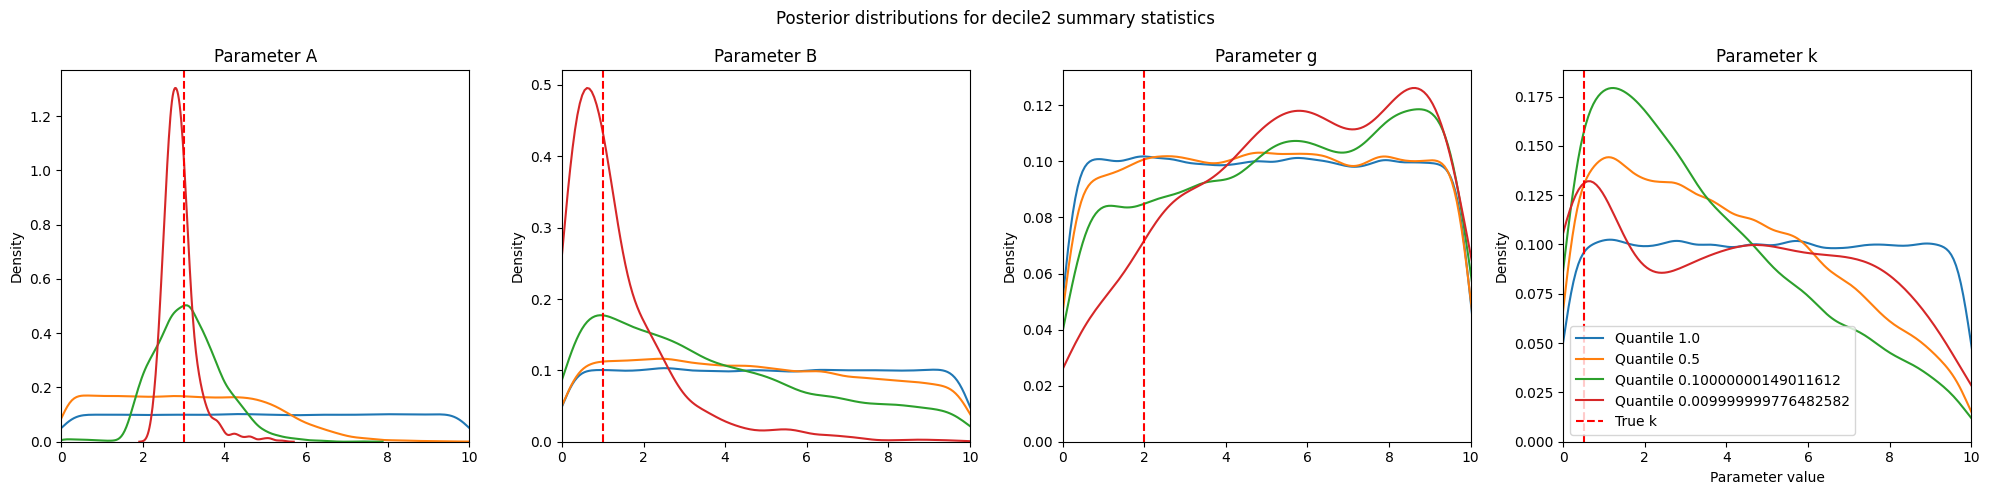

Shapes: summary: (100000, 9), summary_xobs: (9,)


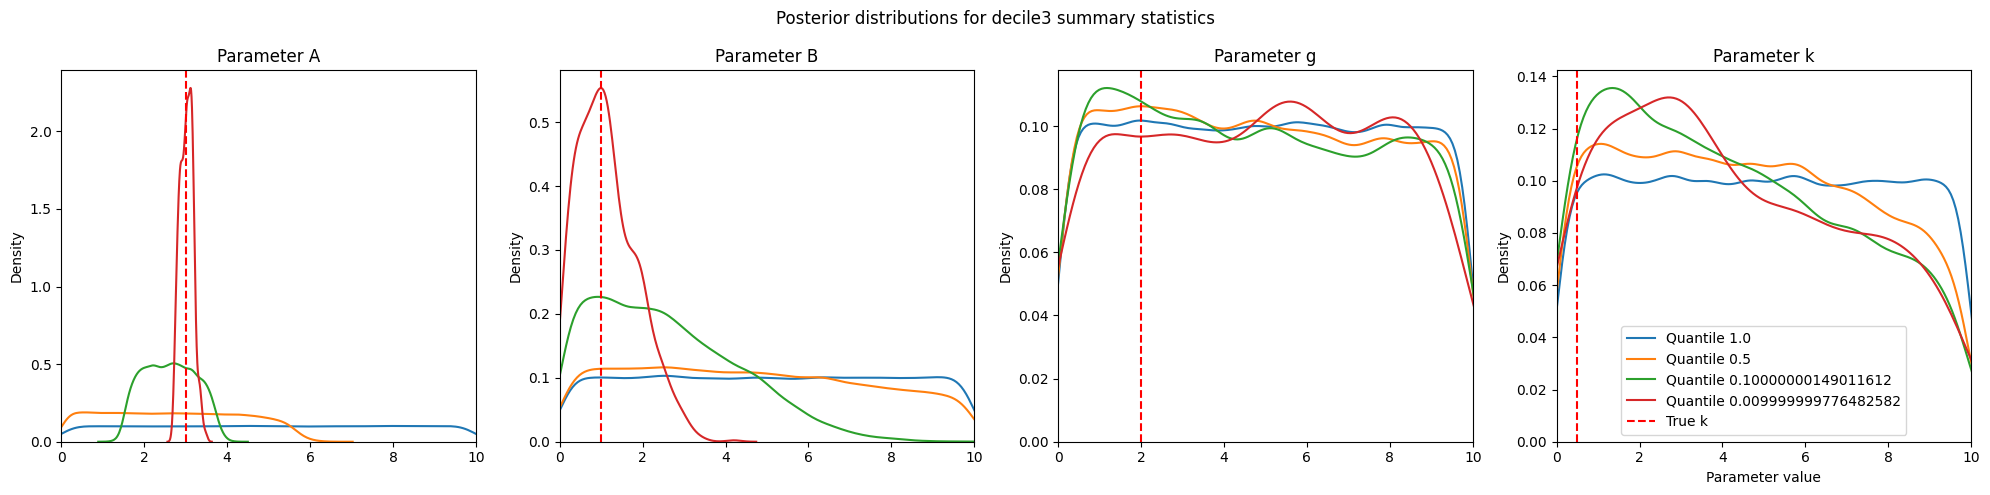

Shapes: summary: (100000, 9), summary_xobs: (9,)


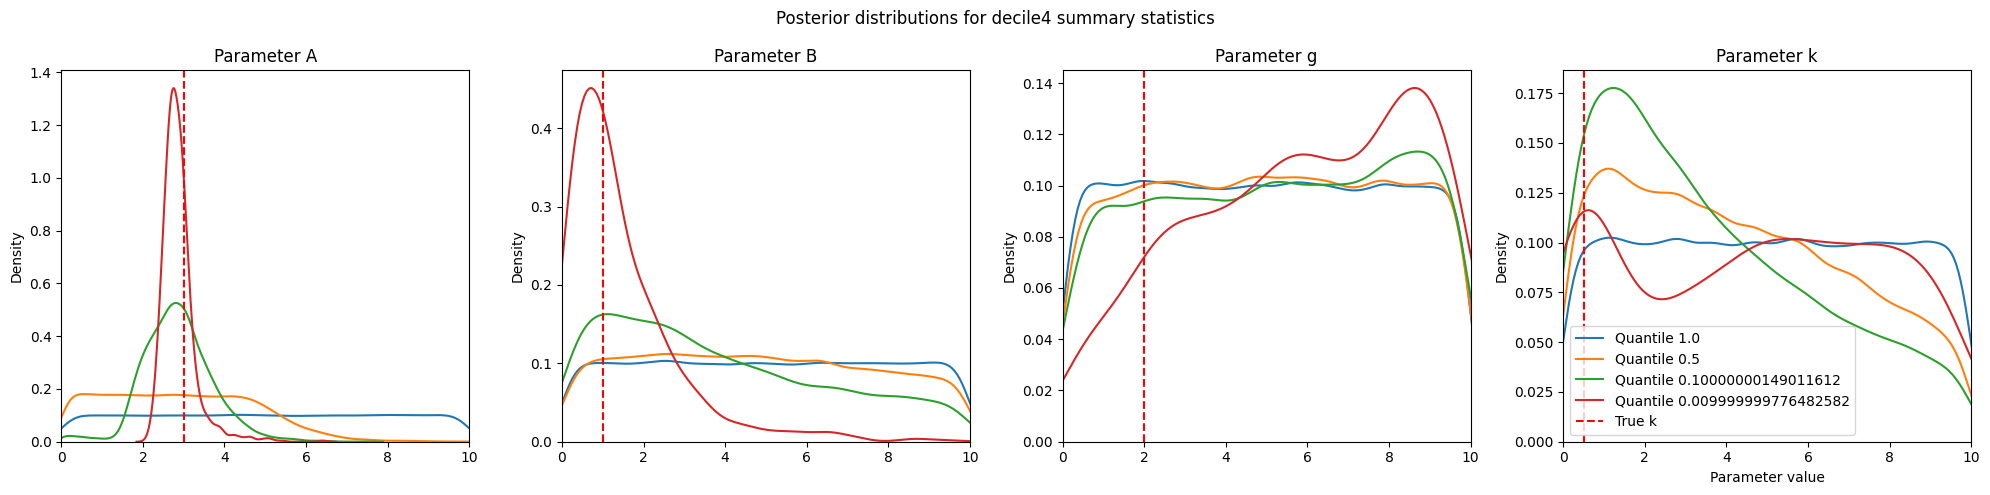

Shapes: summary: (100000, 99), summary_xobs: (99,)


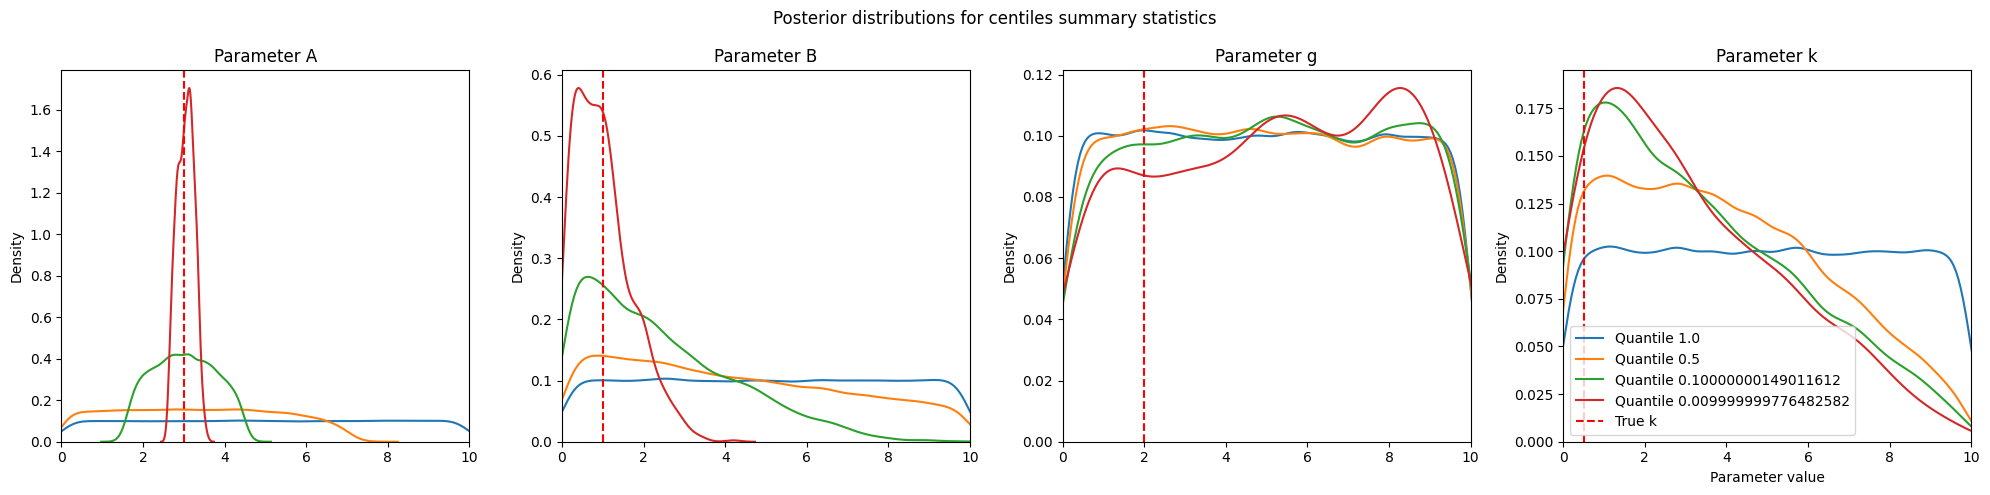

Shapes: summary: (100000, 99), summary_xobs: (99,)


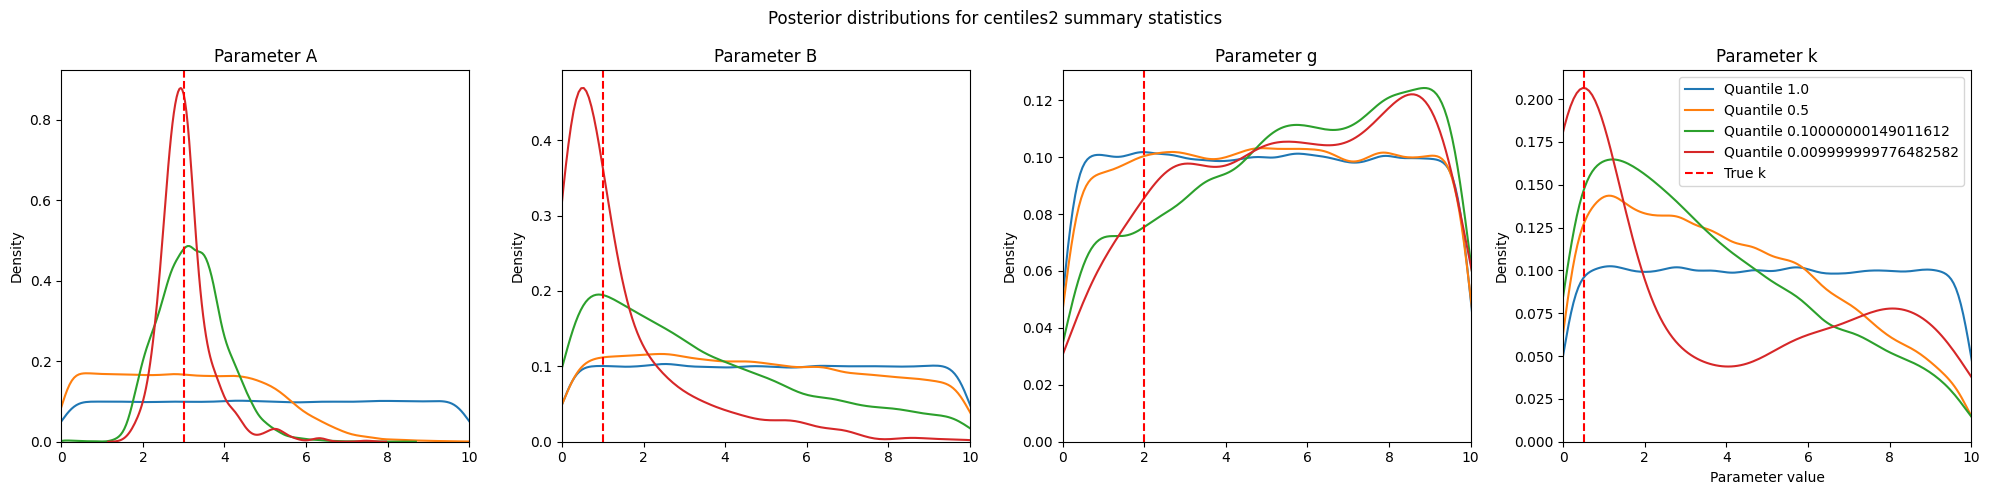

Shapes: summary: (100000, 99), summary_xobs: (99,)


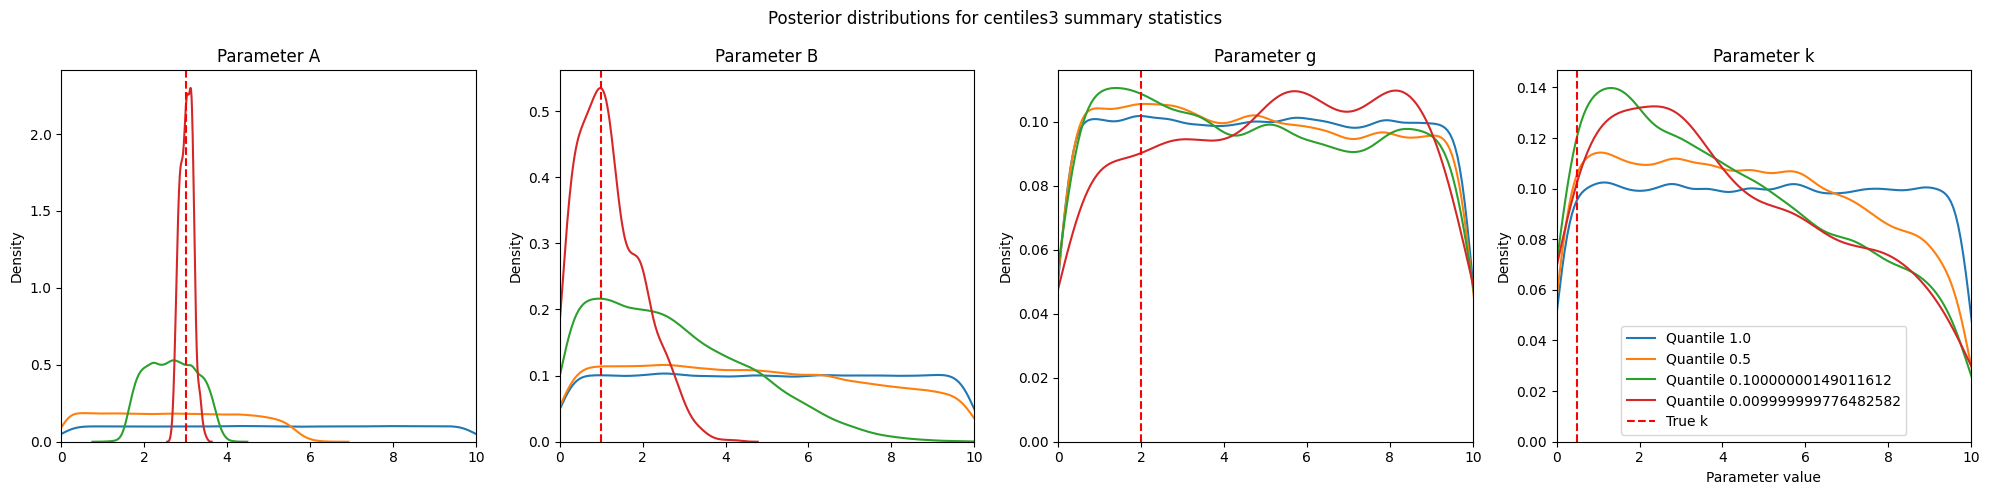

Shapes: summary: (100000, 99), summary_xobs: (99,)


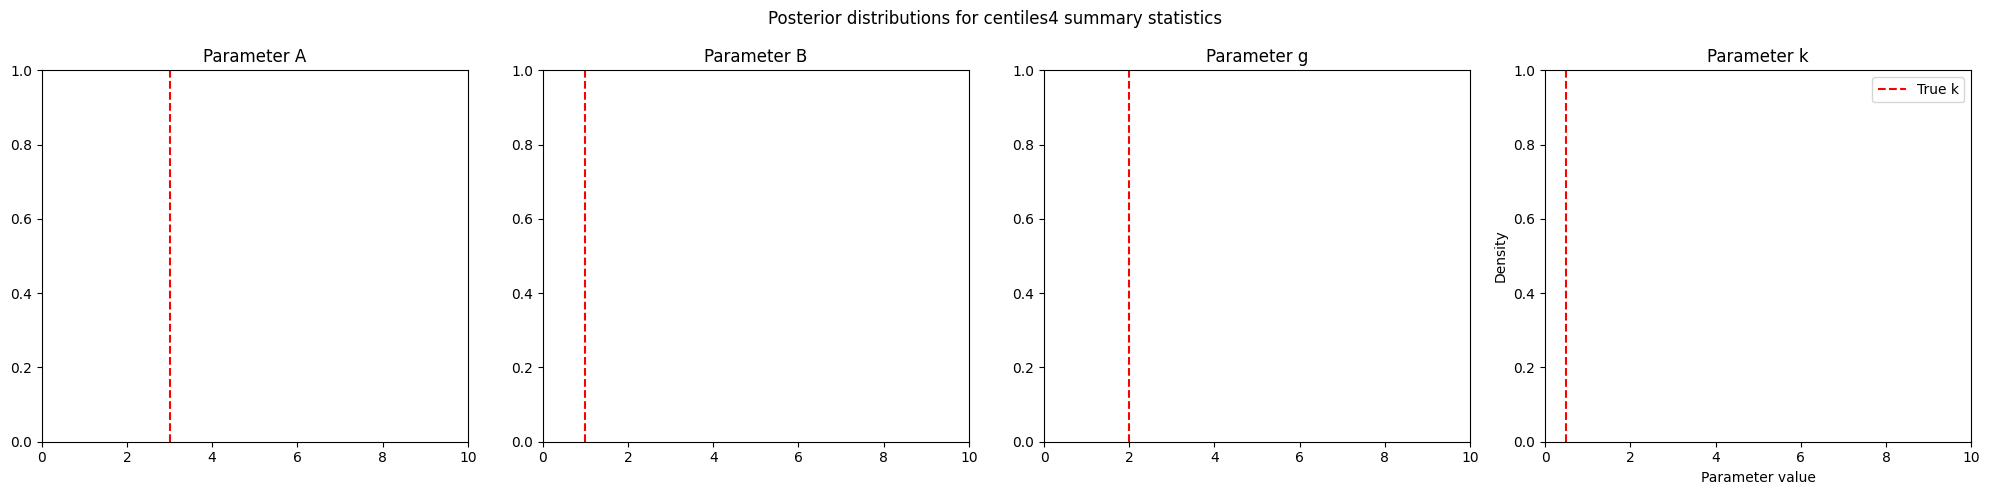

Shapes: summary: (100000, 1000, 1), summary_xobs: (1000, 1)


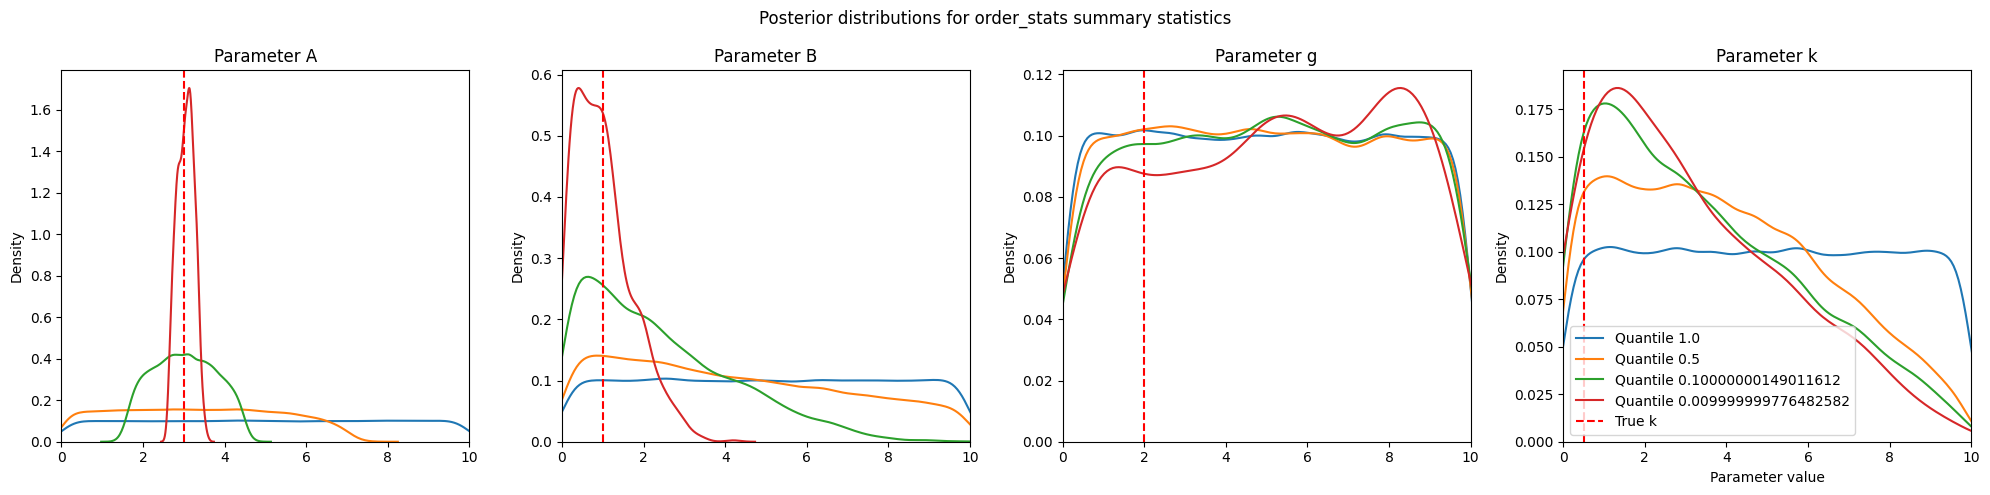

Shapes: summary: (100000, 1000, 1), summary_xobs: (1000, 1)


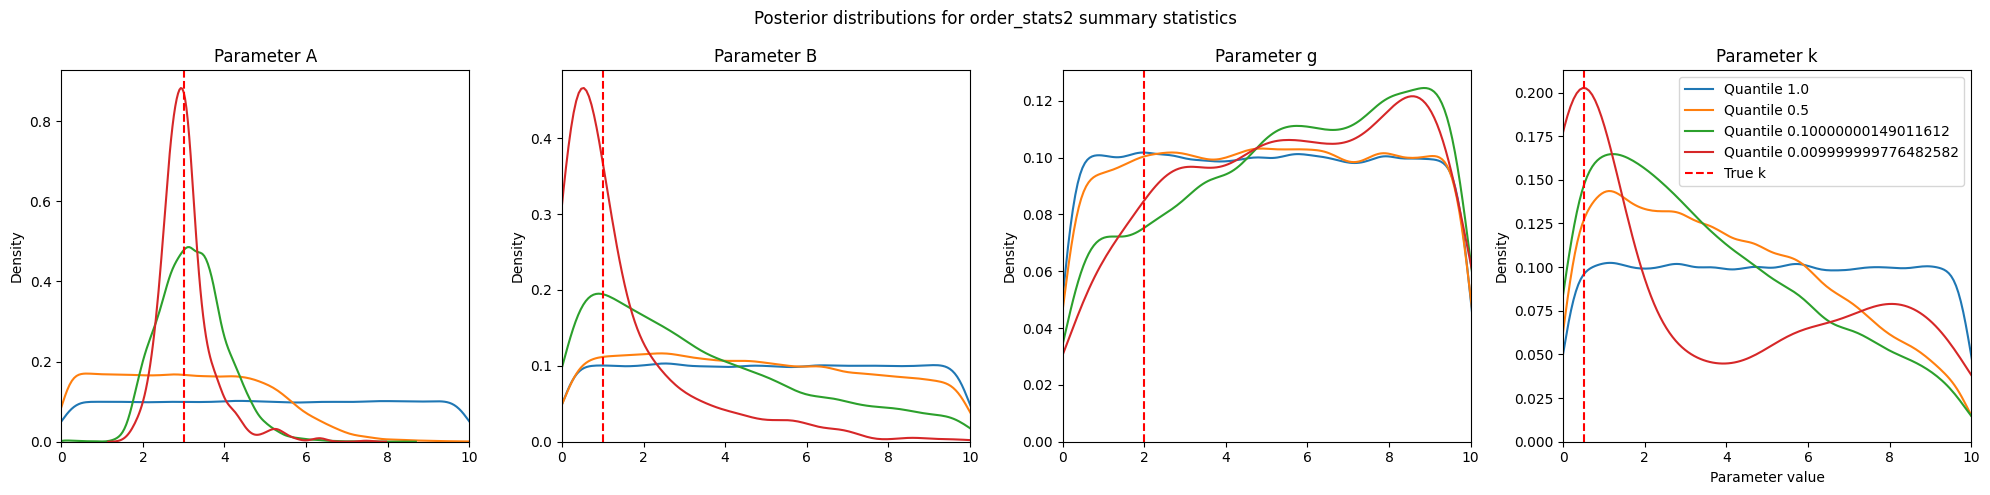

Shapes: summary: (100000, 1000, 1), summary_xobs: (1000, 1)


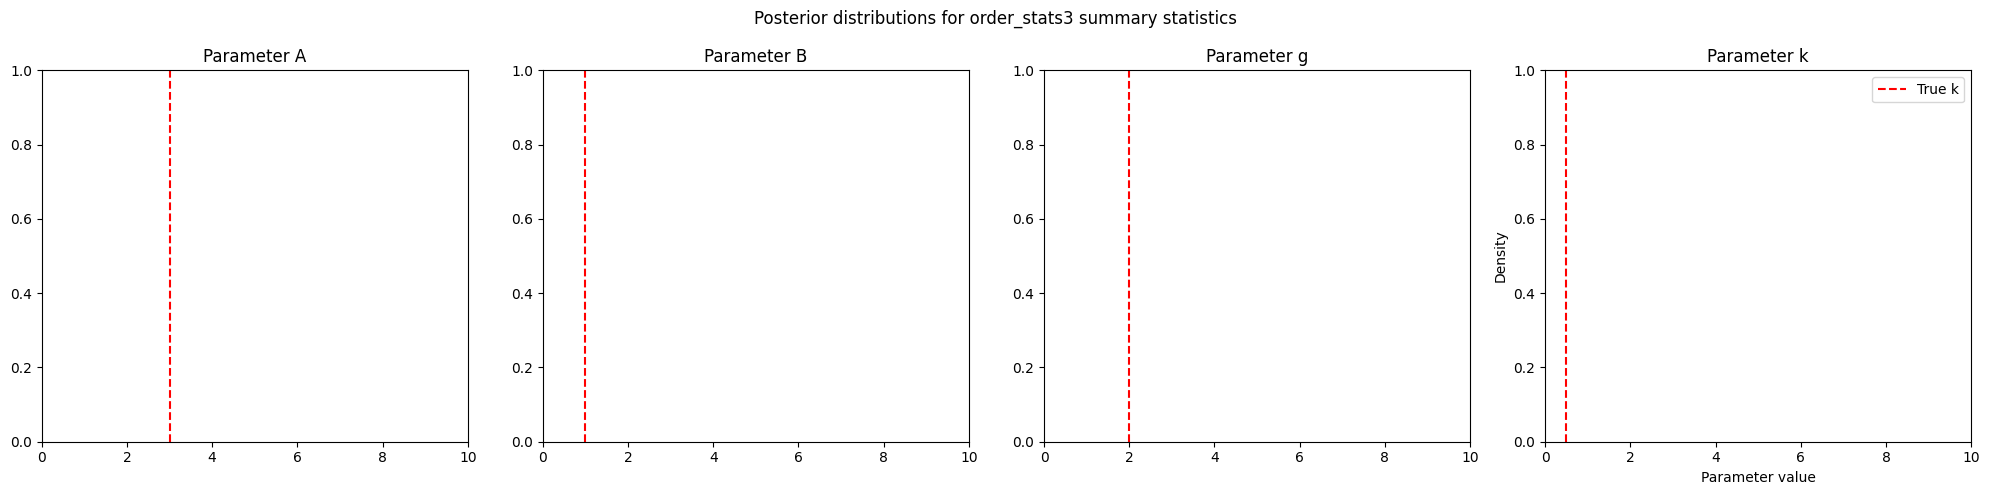

Shapes: summary: (100000, 1000, 1), summary_xobs: (1000, 1)


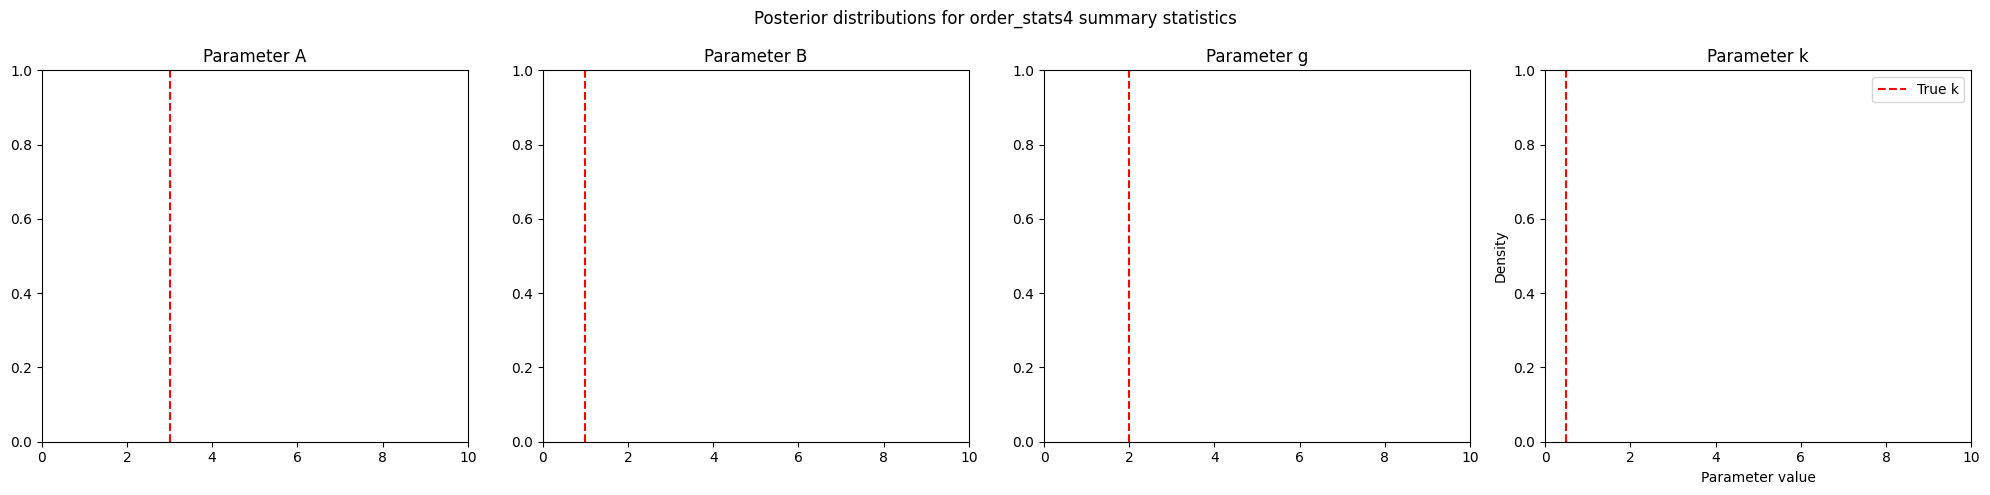

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

quantiles = jnp.array([1., .5, .1, .01])
summarys = [meds, iqrs, skews, octiles, deciles_xs, deciles2_xs, deciles3_xs, deciles4_xs,  centiles_xs, centiles2_xs, centiles3_xs, centiles4_xs,order_stats_xs, order_stats2_xs, order_stats3_xs, order_stats4_xs,]
summarys_xobs = [med_xobs, iqr_xobs, skew_xobs, octile_xobs, deciles_xobs, deciles2_xobs, deciles3_xobs, deciles4_xobs, centiles_xobs, centiles2_xobs, centiles3_xobs, centiles4_xobs, order_stats_xobs, order_stats2_xobs, order_stats3_xobs, order_stats4_xobs]
names = ["med", "iqr", "skew", "octile", "decile", "decile2", "decile3", "decile4", "centiles", "centiles2", "centiles3", "centiles4", "order_stats", "order_stats2", "order_stats3", "order_stats4"]


for summary, summary_xobs, name in zip(summarys, summarys_xobs, names):
    
    std_sum = jnp.std(summary, axis=0)    
    
    print(f'Shapes: summary: {summary.shape}, summary_xobs: {summary_xobs.shape}')
    dists = jnp.linalg.norm((summary - summary_xobs) / std_sum, axis=1)
    f,ax = plt.subplots(1, 4, figsize=(20,5))

    for quantile_distance in quantiles:
        epsilon = jnp.quantile(dists, quantile_distance)
        mask = jnp.where(dists <= epsilon)[0]
        thetas_masked = thetas[mask]
        dists_masked = dists[mask]
        
        sns.kdeplot(thetas_masked[:,0].flatten(), ax=ax[0], label=f"Quantile {quantile_distance}")
        sns.kdeplot(thetas_masked[:,1].flatten(), ax=ax[1], label=f"Quantile {quantile_distance}")
        sns.kdeplot(thetas_masked[:,2].flatten(), ax=ax[2], label=f"Quantile {quantile_distance}")
        sns.kdeplot(thetas_masked[:,3].flatten(), ax=ax[3], label=f"Quantile {quantile_distance}")
    ax[0].set_title("Parameter A")
    ax[1].set_title("Parameter B")
    ax[2].set_title("Parameter g")
    ax[3].set_title("Parameter k")
    ax[0].set_xlim(0, 10)
    ax[1].set_xlim(0, 10)
    ax[2].set_xlim(0, 10)
    ax[3].set_xlim(0, 10)
    ax[0].axvline(true_theta[0], color='red', linestyle='--', label='True A')
    ax[1].axvline(true_theta[1], color='red', linestyle='--', label='True B')
    ax[2].axvline(true_theta[2], color='red', linestyle='--', label='True g')
    ax[3].axvline(true_theta[3], color='red', linestyle='--', label='True k')
    plt.suptitle("Posterior distributions for different quantile distances")
    plt.xlabel("Parameter value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.suptitle(f"Posterior distributions for {name} summary statistics")

        
    plt.legend()
    plt.show()

In [ ]:
for sum